In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import time

import dnnlib
from dnnlib import EasyDict
import dnnlib.tflib as tflib

from networks_progan import *
from progan_object_ious import *

In [2]:
tf.enable_eager_execution()

## Load model

In [625]:
model_dir = './pretrained_models/'
model_name = 'clevr_complex_bl'
model_path = model_dir + model_name + '.pkl'

In [606]:
# weights = {}
# for key in Gs.vars.keys():
#     weights[key] = Gs.get_var(key)
# with open(model_name + '_weights.pickle', 'wb') as handle:
#     pickle.dump(weights, handle)
with open(model_name + '_weights.pickle', 'rb') as handle:
    weights = pickle.load(handle)

## Minimize over a path in a feature space

The general idea:
1. Choose a particular neuron
2. Compute the energy m(x1, x2) = ||V(x1) - V(x2)||_2
3. Minimize \sum_{i=0}^n {m(x_i, x_{i+1})^2}

In [698]:
class PathFinder:
    def __init__(
        self, 
        z1, 
        z2, 
        weights, 
        layer_name, 
        neuron
    ):
        self.z1 = z1
        self.z2 = z2
        self.weights = weights
        self.layer_name = layer_name
        self.neuron = neuron
        self.points = []
               
        self.layers = [
            '4x4/Dense',
            '4x4/Conv',
            '8x8/Conv0_up',
            '8x8/Conv1',
            '16x16/Conv0_up',
            '16x16/Conv1',
            '32x32/Conv0_up',
            '32x32/Conv1',
            '64x64/Conv0_up',
            '64x64/Conv1',
            '128x128/Conv0_up',
            '128x128/Conv1',
        ]
        self.output_shape = {
            '4x4':     [512, 4, 4],
            '8x8':     [8, 8, 512],
            '16x16':   [16, 16, 512],
            '32x32':   [32, 32, 512],
            '64x64':   [64, 64, 256],
            '128x128': [128, 128, 128]
        }
    
    def compute_x(self, z, layer_name, neuron):
        # evaluate the activation for z at this layer
        n = z.shape[0]
        for layer in self.layers:
            layer_dims, layer_type = layer.split('/')
            if layer_type == 'Conv1' or layer_type == 'Conv':
                z = tf.transpose(z, [0, 2, 3, 1])
                w = self.weights[layer + '/weight']
                b = self.weights[layer + '/bias'][0]
                z = tf.nn.conv2d(
                    z, 
                    w, 
                    strides=[1,1,1,1], 
                    padding='SAME', 
                    data_format='NHWC'
                )
                z = tf.transpose(z, [0, 3, 1, 2])
                z = pixel_norm(leaky_relu(z + b))
                
            elif layer_type == 'Conv0_up':
                z = tf.transpose(z, [0, 2, 3, 1])
                w = self.weights[layer + '/weight']
                w = tf.transpose(w, [0, 1, 3, 2]) # [kernel, kernel, fmaps_out, fmaps_in]
                w = tf.pad(w, [[1,1], [1,1], [0,0], [0,0]], mode='CONSTANT')
                w = tf.add_n([w[1:, 1:], w[:-1, 1:], w[1:, :-1], w[:-1, :-1]])
                os = [n] + self.output_shape[layer_dims]
                b = self.weights[layer + '/bias'][0]
                z = tf.nn.conv2d_transpose(
                    z, 
                    w, 
                    os, 
                    strides=[1,2,2,1], 
                    padding='SAME', 
                    data_format='NHWC'
                )
                z = tf.transpose(z, [0, 3, 1, 2])
                z = pixel_norm(leaky_relu(z + b))
            elif layer_type == 'Dense':
                w = self.weights['4x4/Dense/weight']
                b = self.weights['4x4/Dense/bias'][0]
                z = tf.matmul(pixel_norm(z), w) + b
                z = tf.reshape(z, [n] + self.output_shape[layer_dims])
                z = leaky_relu(pixel_norm(z))
            else:
                print('Error: invalid layer {}'.format(layer_name))
                return
            
            if layer == layer_name:
                return z[:,neuron,:,:]
    
    def m(self, z_i, z_j):
        x_i = self.compute_x(z_i, self.layer_name, self.neuron)
        x_j = self.compute_x(z_j, self.layer_name, self.neuron)
        return tf.norm(x_i - x_j)
    
    def compute_loss(self):
        loss_comps = []
        for i in range(len(self.points)):
            if i == 0:
                loss_comps.append(self.m(self.points[i], self.z1)**2)
            else:
                loss_comps.append(self.m(self.points[i], self.points[i - 1])**2)
            loss_comps.append(self.m(self.points[-1], self.z2)**2)
        return tf.add_n(loss_comps)
    
    def run(self, session, n_epochs, lr=0.01):
        opt = tf.train.AdamOptimizer(learning_rate=lr)
        z = tf.Variable(
            initial_value=tf.math.scalar_mul(0.5, tf.math.add(self.z1, self.z2)),
            trainable=True
        )
        self.points.append(z)
        for i in range(1, n_epochs+1):
            print(i, end= ' ')
            if (i % 25 == 0):
                # subdivide the path
                for j in range(len(self.points) + 1):
                    if j == 0:
                        z1 = self.z1
                        z2 = self.points[0]
                    elif j == len(self.points):
                        z1 = self.points[-1]
                        z2 = self.z2
                    else:
                        z1 = self.points[j]
                        z2 = self.points[j - 1] 
                    z = tf.Variable(
                        initial_value=tf.math.scalar_mul(0.5, tf.math.add(z1, z2)),
                        trainable=True
                    )
                    self.points.insert(2 * j, z)
                
            # compute loss and update path points            
            with tf.GradientTape() as tape:
                loss = self.compute_loss()
            var_list = self.points
            grads = tape.gradient(loss, var_list)
            processed_grads = [tf.clip_by_norm(g, 2.0) for g in grads]
            opt.apply_gradients(zip(processed_grads, var_list))
                    
                    

In [ ]:
rnd = np.random.RandomState(1)
latents = rnd.randn(2, 12).astype('float32')
layer = '8x8/Conv1'
neuron = 169
pf = PathFinder(
    np.expand_dims(latents[0], 0), 
    np.expand_dims(latents[1], 0), 
    weights, 
    layer, 
    neuron
)
pf.run(tf.get_default_session(), 124)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 

In [ ]:
print(len(pf.points))

#### Feature path

In [693]:
feature_path = np.zeros((len(pf.points) + 2, 12)).astype('float32')
feature_path[0] = pf.z1
feature_path[-1] = pf.z2
for i,point in enumerate(pf.points):
    feature_path[i+1] = point.numpy()
print(feature_path)

[[ 1.6243454  -0.6117564  -0.5281718  -1.0729686   0.86540765 -2.3015387
   1.7448118  -0.7612069   0.3190391  -0.24937038  1.4621079  -2.0601406 ]
 [ 1.3145151  -0.83133996 -0.3138924  -1.3422426   0.7054708  -1.9390701
   1.4502432  -0.49218705 -0.15658623 -0.29772344  1.4316835  -1.5783201 ]
 [ 0.98454833 -0.85480994 -0.22084741 -1.3859004   0.62296087 -1.7977765
   1.237989   -0.3388674  -0.5159404  -0.2112637   1.3652909  -1.2676233 ]
 [ 1.0093501  -0.9049553  -0.16558893 -1.4899324   0.59116095 -1.7808586
   1.2934923  -0.2613146  -0.51675886 -0.15121791  1.5775434  -1.2053269 ]
 [ 0.43747467 -0.6356147  -0.30246812 -1.191468    0.531168   -1.6049669
   0.7827863  -0.45974678 -0.7311746   0.21786869  1.4144942  -0.7033163 ]
 [ 0.7706291  -0.9942121  -0.00351633 -1.6831822   0.38154626 -1.8821603
   1.1180334  -0.11124645 -0.7807566   0.1344331   1.7940764  -0.83987993]
 [ 0.4479049  -0.48664713  0.08468762 -1.5467287   0.4278589  -1.8217977
   0.8259992  -0.00549807 -1.0955166   

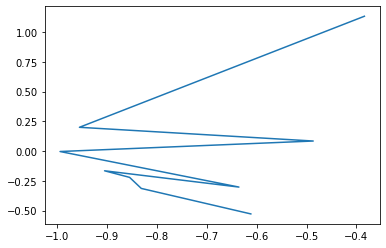

In [694]:
plt.plot(feature_path[:,1], feature_path[:,2])

#### Linear interpolation

In [695]:
linear_path = np.zeros((len(pf.points) + 2, 12)).astype('float32')
linear_path[0] = pf.z1
linear_path[-1] = pf.z2
for i in range(len(pf.points)):
    alpha = (i+1) / (len(pf.points) + 1)
    linear_path[i+1] = (1 - alpha) * pf.z1 + alpha * pf.z2
print(linear_path)

[[ 1.6243454  -0.6117564  -0.5281718  -1.0729686   0.86540765 -2.3015387
   1.7448118  -0.7612069   0.3190391  -0.24937038  1.4621079  -2.0601406 ]
 [ 1.381      -0.5832936  -0.32042915 -1.076334    0.7356782  -2.1235788
   1.531987   -0.59320414  0.14158182 -0.07510863  1.3920432  -1.7398112 ]
 [ 1.1376548  -0.5548309  -0.11268649 -1.0796993   0.6059487  -1.9456186
   1.3191622  -0.42520142 -0.03587547  0.09915313  1.3219787  -1.4194819 ]
 [ 0.8943094  -0.52636814  0.09505615 -1.0830646   0.4762192  -1.7676586
   1.1063375  -0.2571986  -0.21333274  0.27341488  1.2519139  -1.0991526 ]
 [ 0.65096414 -0.49790537  0.3027988  -1.08643     0.34648973 -1.5896986
   0.8935128  -0.08919585 -0.39079005  0.44767663  1.1818492  -0.77882314]
 [ 0.4076188  -0.46944264  0.51054144 -1.0897954   0.21676023 -1.4117385
   0.68068796  0.07880691 -0.5682473   0.6219384   1.1117847  -0.45849377]
 [ 0.16427346 -0.44097984  0.7182841  -1.0931606   0.08703075 -1.2337785
   0.46786326  0.2468097  -0.7457046   

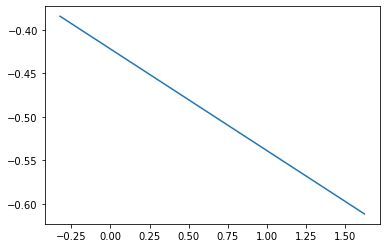

In [696]:
plt.plot(linear_path[:,0], linear_path[:,1])

#### Save interpolations

In [697]:
interps = {}
interps['feature'] = feature_path
interps['linear'] = linear_path

layer_name = '-'.join(layer.split('/'))
with open('interps_{}_{}.pickle'.format(layer_name, neuron), 'wb') as handle:
    pickle.dump(interps, handle)